# Proyecto de Introducción a Data Science
# Uso de Procesamiento de Lenguaje Natural para la Clasificación de Informes de Práctica Pre Profesional

#### Equipo H-ROCHIS:
- David Araya, 20.767.691-8
- Jorge Rivera, 20.416.699-4
- José Alcayaga,  20.967.432-7

<br>

---

# Resumen Ejecutivo

Durante el proceso de revisión de los informes de práctica del DISC (Departamento de Ingeniería de Sistemas y Computación), se requiere una inversión considerable de tiempo que, hasta la fecha, no ha sido automatizada. Esto conlleva largas jornadas de trabajo y carga adicional para los académicos, quienes podrían emplear ese tiempo en otras labores. Por lo tanto, como equipo de trabajo, hemos llegado a un consenso en la necesidad de llevar a cabo el análisis y desarrollo de un modelo que permita clasificar los informes en las categorías definidas en la rúbrica actual (insatisfactorio, regular, bueno y excelente).
Es importante destacar que, con la llegada de la pandemia, la entrega de informes ha sido en formato digital, lo que ha generado un conjunto de aproximadamente 100 informes disponibles. Esta digitalización ofrece ventajas significativas para el entrenamiento del modelo, ya que se dispone de datos de entrada y resultados concretos (informe, rúbrica y nota).

## Objetivo General

Desarrollar un sistema basado en técnicas de aprendizaje automático que permita la clasificación automatizada de informes de práctica del DISC en las categorías definidas en la rúbrica actual (insatisfactorio, regular, bueno y excelente), utilizando como base un conjunto de datos digitalizados de aproximadamente 100 informes.

## Objetivos Específicos
1. Preprocesar un conjunto de informes digitalizados para ser utilizados como datos de entrenamiento y prueba.
2. Entrenar uno o varios modelos de aprendizaje automático utilizando técnicas de procesamiento de lenguaje natural (NLP).
3. Evaluar las diferencias entre el conjunto inicial y las clasificaciones del modelo.

## Progresos por cada Objetivo Especifico
1. Se optimiza de manera preliminar el contenido de los informes para ser procesados por modelos modernos de representación, como BERT. En particular, se divide un informe en un conjunto de bloques de información, los cuales son obtenidos directamente de la librería PyMuPDF.
2. En lo que respecta a métodos tradicionales, se prueban modelos de salidas múltiples, para obtener las predicciones de los distintos elementos de la rúbrica. De manera experimental, se definen tambien modelos para predecir la calificación final en base a los elementos de la rúbrica. Además, se agrega al conjunto de modelos: un clasificador Naïve Bayes, un bosque aleatorio, y un árbol de decisión mejorado por gradiente, por parte de la librería XGBoost.
Para aumentar el rendimiento de los modelos, se aplicó búsqueda de hiperparámetros por grilla.
Pasando a métodos de deep learning, se implementa un modelo basado en LSTM, que predice cada elemento de la rúbrica de manera independiente. En particular, se generan 2 modelos bases, para los distintos métodos de representación que se probaron. De estos, se generaron siete instancias, para los seis elementos de la rúbrica y la calificación final.
3. Se evaluó el rendimiento de los modelos basados en Deep Learning. En general, ninguno de los modelos obtuvo una exactitud mayor a 60%, teniendo la mayoría uno menor a 50%. Por el lado de los modelos tradicionales, los nuevos modelos integrados tienen una  puntuación similar o peor a los modelos previamente mostrados: 56% para Naïve Bayes, 54% para bosque aleatorio, y 43% para XGBoost; y los modelos de multiple salida presentan valores de presición menores a 10%.

> **Nota:** Las dos celdas siguientes contienen los comandos necesarios para instalar las bibliotecas utilizadas a lo largo del cuaderno. Puedes ejecutarlas directamente como celdas de código o copiar y pegar cada comando en una terminal, excluyendo el signo de exclamación.

In [1]:
# Librerías generales
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Procesamiento de texto
import spacy
from spacy_transformers import Transformer
from spacy_transformers.pipeline_component import DEFAULT_CONFIG
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import RobertaTokenizer, RobertaModel
from transformers import AutoTokenizer, AutoModel
from tensorflow import keras
import tensorflow as tf
import tensorflow_text
import tensorflow_hub as hub
from transformers import pipeline

# Machine Learning
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, LogisticRegression, LinearRegression
from sklearn.naive_bayes import MultinomialNB, CategoricalNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier
from classy_classification import ClassyClassifier
import torch

# PDF handling
import fitz

# Red neuronal con Keras
from keras.layers import Embedding, LSTM, Bidirectional, Dense
from keras.models import Sequential, clone_model
from keras import utils

# Operaciones numéricas
from numpy import floor

# Tabulate para imprimir tablas
from tabulate import tabulate

# Definición de Funciones a Utilizar

In [2]:
def get_classification(grade, number=False):
    grade = round(grade, 1)
    if grade < 4:
        return "insatisfactorio" if not number else 0
    elif 4 <= grade < 5.5:
        return "regular" if not number else 1
    elif 5.5 <= grade < 6.5:
        return "bueno" if not number else 2
    elif 6.5 <= grade <= 7:
        return "excelente" if not number else 3

def get_final_grade(rubric_grades):
    result = rubric_grades["estructura"] * 0.5
    result += rubric_grades["escritura"] * 0.15
    result += rubric_grades["contenido"] * 0.25
    result += rubric_grades["conclusiones"] * 0.15
    result += rubric_grades["conocimiento"] * 0.30
    result += rubric_grades["relevancia"] * 0.10
    return floor(result)

def print_formatted_table(column_names, *columns):
    columns = [[value.capitalize() if isinstance(value, str) else value for value in col] for col in columns]
    data = list(zip(*columns))
    print(tabulate(data, headers=column_names, tablefmt="fancy_grid"))

def print_parameters(parameters):
    table_data = [(key, value) for key, value in parameters.items()]
    print(tabulate(table_data, headers=["Parámetro", "Valor"], tablefmt="fancy_grid"))

def print_metrics(metrics):
    table_data = [(metric_name, metric_value) for metric_name, metric_value in metrics.items()]
    print(tabulate(table_data, headers=["Métrica", "Valor"], tablefmt="fancy_grid"))

def replace_period(value):
    replacement_dict = {'2021-1': 20211,
                        '2021-2': 20212,
                        '2022-1': 20221,
                        '2022-2': 20222,
                        '2020-1': 20201,
                        '2020-2': 20202,
                        '2023-1': 20231,
                        '2022-1R': 202215,
                        '2020-2R': 202015
                        }
    return replacement_dict.get(value, value)

def fill_values(mtx, values: list, tags_values: list, tag):
    for row in mtx[tag]:
        values.append(row)
        tags_values.append(tag)
    return values, tags_values

---

# Recolección de Datos

En esta sección, se carga la información del archivo "calificaciones.xlsx" en el dataframe dataset.

In [3]:
# Carga del dataset
dataset = pd.read_excel("calificaciones.xlsx", decimal=",")

---

# Procesamiento de Datos

En esta sección, se identifican y seleccionan las columnas relevantes para las calificaciones y la rúbrica, excluyendo aquellas innecesarias. Luego, se procede a eliminar las filas que contienen valores nulos en las columnas de calificaciones. Posteriormente, se inicia el procesamiento de documentos en formato PDF con el propósito de extraer información relevante e incorporarla al conjunto de datos.

Se implementa la clasificación de documentos basada en las calificaciones obtenidas en cada entrada, siguiendo las categorías predefinidas en la rúbrica. Cada nota asociada a los componentes de cada informe se sustituye por un elemento que representa la categoría correspondiente. Este elemento puede ser un texto que refleje directamente el nombre de la categoría o un número, variando desde 0 para "insuficiente" hasta 3 para "excelente".

La elección entre texto y número tiene un propósito específico: el texto se utiliza exclusivamente para el modelo Classy Classification, mientras que los números se emplean para los demás modelos. Esta adaptación facilita la integración de los datos clasificados en los diferentes modelos, asegurando la coherencia necesaria para cada enfoque de análisis.

In [4]:
grades_columns = dataset.columns.difference(["id", "periodo", "Unnamed: 9"])
rubric_columns = grades_columns.difference(["total"])
dataset = dataset.dropna(subset=grades_columns)

documents = []

for id in dataset["id"]:
    pdf_file = fitz.open(f"dataset/{id}.pdf")
    document_text = chr(12).join([page.get_text() for page in pdf_file])
    documents.append(document_text)

vdf = dataset.copy()

dataset.insert(loc=2, column="documents", value=documents)

text_labeled_dataset = dataset.copy()
text_labeled_dataset.loc[:, grades_columns] = text_labeled_dataset.loc[:, grades_columns].apply(lambda s: s.apply(get_classification))

dataset.loc[:, grades_columns] = dataset.loc[:, grades_columns].apply(lambda s: s.apply(lambda x: get_classification(grade=x, number=True)))

---

# Exploración y Visualización

In [5]:
ESTRUCTURA_COLUMN = 'estructura'
ESCRITURA_COLUMN = 'escritura'
CONTENIDO_COLUMN = 'contenido'
CONCLUSIONES_COLUMN = 'conclusiones'
CONOCIMIENTO_COLUMN = 'conocimiento'
RELEVANCIA_COLUMN = 'relevancia'
TOTAL_COLUMN = 'total'
PERIODO_COLUMN = 'periodo'
ID_COLUMN = 'id'

## Heatmap de Total vs Período

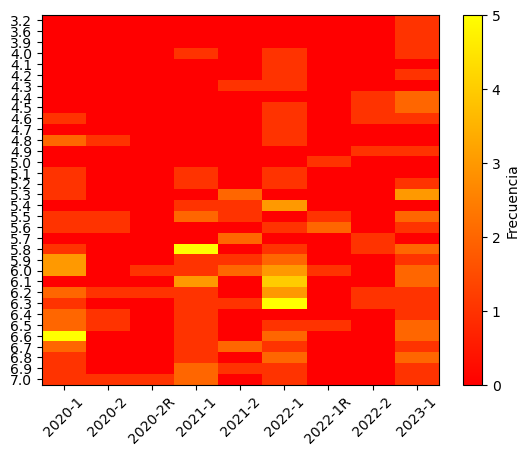

In [6]:
hmap_vdf = vdf.copy()

heatmap_data = hmap_vdf.pivot_table(index='total', columns=PERIODO_COLUMN, aggfunc='size', fill_value=0)

plt.imshow(heatmap_data, cmap='autumn', aspect='auto')
plt.xticks(np.arange(len(heatmap_data.columns)), heatmap_data.columns, rotation=45)
plt.yticks(np.arange(len(heatmap_data.index)), heatmap_data.index)
plt.colorbar(label='Frecuencia')
plt.show()

## Heatmap de Clasificación por cada ítem de la rúbrica

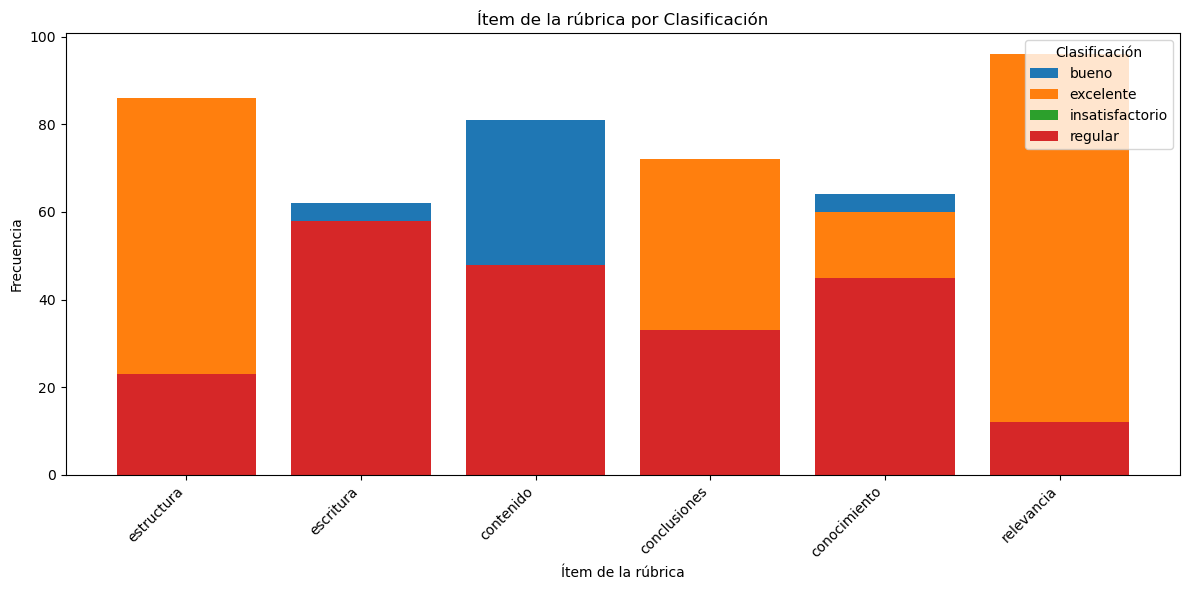

In [7]:
map_vdf = vdf.copy()

map_vdf[ESTRUCTURA_COLUMN] = map_vdf[ESTRUCTURA_COLUMN].apply(get_classification)
map_vdf[ESCRITURA_COLUMN] = map_vdf[ESCRITURA_COLUMN].apply(get_classification)
map_vdf[CONTENIDO_COLUMN] = map_vdf[CONTENIDO_COLUMN].apply(get_classification)
map_vdf[CONCLUSIONES_COLUMN] = map_vdf[CONCLUSIONES_COLUMN].apply(get_classification)
map_vdf[CONOCIMIENTO_COLUMN] = map_vdf[CONOCIMIENTO_COLUMN].apply(get_classification)
map_vdf[RELEVANCIA_COLUMN] = map_vdf[RELEVANCIA_COLUMN].apply(get_classification)

all_classifications = np.unique(map_vdf[[ESTRUCTURA_COLUMN, ESCRITURA_COLUMN, CONTENIDO_COLUMN,
                                         CONCLUSIONES_COLUMN, CONOCIMIENTO_COLUMN, RELEVANCIA_COLUMN]].values)

new_values = []
tags_values = []

for tag in [ESTRUCTURA_COLUMN, ESCRITURA_COLUMN, CONTENIDO_COLUMN, CONCLUSIONES_COLUMN, CONOCIMIENTO_COLUMN, RELEVANCIA_COLUMN]:
    new_values, tags_values = fill_values(map_vdf, new_values, tags_values, tag)

hmp_set = pd.DataFrame({'Clasificación': new_values, 'Ítem de la rúbrica': tags_values})

plt.figure(figsize=(12, 6))
for classification in all_classifications:
    subset = hmp_set[hmp_set['Clasificación'] == classification]
    counts = subset['Ítem de la rúbrica'].value_counts().reindex(hmp_set['Ítem de la rúbrica'].unique(), fill_value=0)
    plt.bar(counts.index, counts, label=classification)

plt.xlabel('Ítem de la rúbrica')
plt.ylabel('Frecuencia')
plt.title('Ítem de la rúbrica por Clasificación')
plt.legend(title='Clasificación', loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

---

# Análisis y Machine Learning

## Clasificación de documentos con métodos tradicionales

SciKit-Learn será la herramienta empleada para analizar documentos a través de métodos tradicionales de NLP, centrándose especialmente en TF-IDF. En esta fase, se implementa la división en conjuntos de prueba y validación, además de aplicar la vectorización.

Posteriormente, se recurrirá a diversos modelos de Machine Learning para llevar a cabo la clasificación de los documentos. Entre estos modelos se incluyen la regresión lineal y logística, SVM, árboles de decisión y Naïve Bayes.

In [8]:
Xn = dataset["documents"]
yn = dataset[grades_columns]
X_train, X_test, y_train, y_test = train_test_split(Xn, yn, random_state=3, test_size=0.3)
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.9, min_df=0.2)
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

### Estimadores de calificación final

A modo de experimentación, para obtener un modelo que pueda predecir una calificación final considerando una predicción de todos los elementos, se intentan hacer modelos que puedan definir la categoría final en base a los elementos de la rúbrica. Además, se prueba aplicando la fórmula de nota final considerando solamente las categorías de la rúbrica.

In [9]:
y_calc = get_final_grade(yn[rubric_columns])
acc = accuracy_score(y_calc, yn["total"])

metrics_dict = {"Accuracy": acc}
print_metrics(metrics_dict)

╒═══════════╤═════════╕
│ Métrica   │   Valor │
╞═══════════╪═════════╡
│ Accuracy  │ 0.33908 │
╘═══════════╧═════════╛


#### Calificación final con Random Forest

In [10]:
param_grid = {
    "random_state": [1, 5, 10, 12, 27, 42, 64, 130],
    "n_estimators": [100, 150, 175, 200],
    "max_depth": [1, 3, 5, 6, 7, 10],
}
rf = RandomForestClassifier()
grid = GridSearchCV(rf, param_grid, scoring=("accuracy", "f1_weighted"), refit="accuracy", cv=3)
grid.fit(X_train_bow, y_train["total"])

print_parameters(grid.best_params_)

╒══════════════╤═════════╕
│ Parámetro    │   Valor │
╞══════════════╪═════════╡
│ max_depth    │       5 │
├──────────────┼─────────┤
│ n_estimators │     100 │
├──────────────┼─────────┤
│ random_state │      12 │
╘══════════════╧═════════╛


In [11]:
final_grade_rf = RandomForestClassifier(n_estimators=100, random_state=12, max_depth=5)
final_grade_rf.fit(y_train[rubric_columns], y_train["total"])
grade_pred_rf = final_grade_rf.predict(y_test[rubric_columns])

acc = accuracy_score(y_test["total"], grade_pred_rf)
f1 = f1_score(y_test["total"], grade_pred_rf, average="weighted")

metrics_dict = {"Accuracy": acc, "F1": f1}
print_metrics(metrics_dict)

╒═══════════╤══════════╕
│ Métrica   │    Valor │
╞═══════════╪══════════╡
│ Accuracy  │ 0.849057 │
├───────────┼──────────┤
│ F1        │ 0.852467 │
╘═══════════╧══════════╛


In [12]:
print_formatted_table(["Rúbrica", "Importancia"], rubric_columns, final_grade_rf.feature_importances_)

╒══════════════╤═══════════════╕
│ Rúbrica      │   Importancia │
╞══════════════╪═══════════════╡
│ Conclusiones │     0.160032  │
├──────────────┼───────────────┤
│ Conocimiento │     0.254586  │
├──────────────┼───────────────┤
│ Contenido    │     0.297605  │
├──────────────┼───────────────┤
│ Escritura    │     0.169235  │
├──────────────┼───────────────┤
│ Estructura   │     0.0423174 │
├──────────────┼───────────────┤
│ Relevancia   │     0.0762244 │
╘══════════════╧═══════════════╛


#### Calificación final con SVC

In [13]:
param_grid = {
    "C": [1, 5, 10, 50, 100, 500, 1000]
}
final_grade_svc_n = SVC()
grid = GridSearchCV(final_grade_svc_n, param_grid, scoring=("accuracy", "f1_weighted"), refit="accuracy", cv=3)
grid.fit(y_train[rubric_columns], y_train["total"])

print_parameters(grid.best_params_)

╒═════════════╤═════════╕
│ Parámetro   │   Valor │
╞═════════════╪═════════╡
│ C           │       1 │
╘═════════════╧═════════╛


In [14]:
final_grade_svc_n = SVC(C=10)
final_grade_svc_n.fit(y_train[rubric_columns], y_train["total"])
grade_pred = final_grade_svc_n.predict(y_test[rubric_columns])

acc = accuracy_score(y_test["total"], grade_pred)
f1 = f1_score(y_test["total"], grade_pred, average="weighted")

metrics_dict = {"Accuracy": acc, "F1": f1}
print_metrics(metrics_dict)

╒═══════════╤══════════╕
│ Métrica   │    Valor │
╞═══════════╪══════════╡
│ Accuracy  │ 0.830189 │
├───────────┼──────────┤
│ F1        │ 0.840147 │
╘═══════════╧══════════╛


#### Calificación final con Regresión Logística

In [15]:
param_grid = {
    "C": [1, 5, 10, 50, 100, 500, 1000]
}
final_grade_log = LogisticRegression(max_iter=1000)
grid = GridSearchCV(final_grade_log, param_grid, scoring=("accuracy", "f1_weighted"), refit="accuracy", cv=3)
grid.fit(y_train[rubric_columns], y_train["total"])

print_parameters(grid.best_params_)

╒═════════════╤═════════╕
│ Parámetro   │   Valor │
╞═════════════╪═════════╡
│ C           │       5 │
╘═════════════╧═════════╛


In [16]:
final_grade_log = LogisticRegression(max_iter=1000, C=5)
final_grade_log.fit(y_train[rubric_columns], y_train["total"])
grade_pred_log = final_grade_log.predict(y_test[rubric_columns])

acc = accuracy_score(y_test["total"], grade_pred_log)
f1 = f1_score(y_test["total"], grade_pred_log, average="weighted")

metrics_dict = {"Accuracy": acc, "F1": f1}
print_metrics(metrics_dict)

╒═══════════╤══════════╕
│ Métrica   │    Valor │
╞═══════════╪══════════╡
│ Accuracy  │ 0.867925 │
├───────────┼──────────┤
│ F1        │ 0.868735 │
╘═══════════╧══════════╛


#### Calificación final con Naïve Bayes

In [17]:
param_grid = {
    "alpha": [0.01, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
}
final_grade_nb = CategoricalNB()
grid = GridSearchCV(final_grade_nb, param_grid, scoring=("accuracy", "f1_weighted"), refit="accuracy", cv=3)
grid.fit(y_train[rubric_columns], y_train["total"])

print_parameters(grid.best_params_)

╒═════════════╤═════════╕
│ Parámetro   │   Valor │
╞═════════════╪═════════╡
│ alpha       │       5 │
╘═════════════╧═════════╛


In [18]:
final_grade_nb = CategoricalNB()
final_grade_nb.fit(y_train[rubric_columns], y_train["total"])
grade_pred_nb = final_grade_nb.predict(y_test[rubric_columns])

acc = accuracy_score(y_test["total"], grade_pred_nb)
f1 = f1_score(y_test["total"], grade_pred_nb, average="weighted")

metrics_dict = {"Accuracy": acc, "F1": f1}
print_metrics(metrics_dict)

╒═══════════╤══════════╕
│ Métrica   │    Valor │
╞═══════════╪══════════╡
│ Accuracy  │ 0.849057 │
├───────────┼──────────┤
│ F1        │ 0.850329 │
╘═══════════╧══════════╛


#### Calificación final con XGBoost

In [19]:
param_grid = {
    "n_estimators": [150, 175, 200],
    "learning_rate": [0.1, 0.2, 0.3],
    "reg_lambda": [0.5, 1, 2],
    "reg_alpha": [0.25, 0.5, 0.75],
}
final_grade_xgb = XGBClassifier()
grid = GridSearchCV(final_grade_xgb, param_grid, scoring=("accuracy", "f1_weighted"), refit="accuracy", cv=3)
grid.fit(yn[rubric_columns], yn["total"])

print_parameters(grid.best_params_)

╒═══════════════╤═════════╕
│ Parámetro     │   Valor │
╞═══════════════╪═════════╡
│ learning_rate │    0.1  │
├───────────────┼─────────┤
│ n_estimators  │  150    │
├───────────────┼─────────┤
│ reg_alpha     │    0.25 │
├───────────────┼─────────┤
│ reg_lambda    │    1    │
╘═══════════════╧═════════╛


In [20]:
final_grade_xgb = XGBClassifier(n_estimators=150, learning_rate=0.1, reg_alpha=0.25)
final_grade_xgb.fit(y_train[rubric_columns], y_train["total"])
grade_pred_xgb = final_grade_xgb.predict(y_test[rubric_columns])

acc = accuracy_score(y_test["total"], grade_pred_xgb)
f1 = f1_score(y_test["total"], grade_pred_xgb, average="weighted")

metrics_dict = {"Accuracy": acc, "F1": f1}
print_metrics(metrics_dict)

╒═══════════╤══════════╕
│ Métrica   │    Valor │
╞═══════════╪══════════╡
│ Accuracy  │ 0.811321 │
├───────────┼──────────┤
│ F1        │ 0.82288  │
╘═══════════╧══════════╛


### Estimadores de calificación por documento

#### Clasificación de documentos con SVM

In [21]:
param_grid = {
    "C": [1, 5, 10, 50, 100, 500, 1000]
}
svc_n = SVC()
grid = GridSearchCV(svc_n, param_grid, scoring=("accuracy", "f1_weighted"), refit="accuracy", cv=3)
grid.fit(X_train_bow, y_train["total"])

print_parameters(grid.best_params_)

╒═════════════╤═════════╕
│ Parámetro   │   Valor │
╞═════════════╪═════════╡
│ C           │       5 │
╘═════════════╧═════════╛


In [22]:
svc_n = SVC(C=5)
svc_n.fit(X_train_bow, y_train["total"])
y_pred = svc_n.predict(X_test_bow)
acc = accuracy_score(y_test["total"], y_pred)
f1 = f1_score(y_test["total"], y_pred, average="weighted")

metrics_dict = {"Accuracy": acc, "F1": f1}
print_metrics(metrics_dict)

╒═══════════╤══════════╕
│ Métrica   │    Valor │
╞═══════════╪══════════╡
│ Accuracy  │ 0.584906 │
├───────────┼──────────┤
│ F1        │ 0.551627 │
╘═══════════╧══════════╛


In [23]:
svc_n_mo = MultiOutputClassifier(svc_n)
svc_n_mo.fit(X_train_bow, y_train[rubric_columns])
y_pred_mo = svc_n_mo.predict(X_test_bow)

acc_mo = svc_n_mo.score(X_test_bow, y_test[rubric_columns])

metrics_dict = {"Accuracy": acc_mo}
print_metrics(metrics_dict)

╒═══════════╤═══════════╕
│ Métrica   │     Valor │
╞═══════════╪═══════════╡
│ Accuracy  │ 0.0754717 │
╘═══════════╧═══════════╛


#### Clasificación de documentos con Regresión Ridge

In [24]:
param_grid = {
    "alpha": [0.01, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
}
ridge = RidgeClassifier(max_iter=1000)
grid = GridSearchCV(ridge, param_grid, scoring=("accuracy", "f1_weighted"), refit="accuracy", cv=3)
grid.fit(X_train_bow, y_train["total"])

print_parameters(grid.best_params_)

╒═════════════╤═════════╕
│ Parámetro   │   Valor │
╞═════════════╪═════════╡
│ alpha       │       5 │
╘═════════════╧═════════╛


In [25]:
ridge = RidgeClassifier()
ridge.fit(X_train_bow, y_train["total"])
y_pred_r = ridge.predict(X_test_bow)

acc_r = accuracy_score(y_test["total"], y_pred_r)
f1_r = f1_score(y_test["total"], y_pred_r, average="weighted")

metrics_dict = {"Accuracy": acc_r, "F1": f1_r}
print_metrics(metrics_dict)

╒═══════════╤══════════╕
│ Métrica   │    Valor │
╞═══════════╪══════════╡
│ Accuracy  │ 0.566038 │
├───────────┼──────────┤
│ F1        │ 0.527525 │
╘═══════════╧══════════╛


In [26]:
ridge_mo = MultiOutputClassifier(ridge)
ridge_mo.fit(X_train_bow, y_train[rubric_columns])
y_pred_r_mo = ridge_mo.predict(X_test_bow)

acc_r_mo = ridge_mo.score(X_test_bow, y_test[rubric_columns])

metrics_dict = {"Accuracy": acc_r_mo}
print_metrics(metrics_dict)

╒═══════════╤═══════════╕
│ Métrica   │     Valor │
╞═══════════╪═══════════╡
│ Accuracy  │ 0.0377358 │
╘═══════════╧═══════════╛


#### Clasificación de documentos con Regresión Logística

In [27]:
param_grid = {
    "C": [1, 5, 10, 50, 100, 500, 1000]
}
log = LogisticRegression(max_iter=1000)
grid = GridSearchCV(log, param_grid, scoring=("accuracy", "f1_weighted"), refit="accuracy", cv=3)
grid.fit(X_train_bow, y_train["total"])

print_parameters(grid.best_params_)

╒═════════════╤═════════╕
│ Parámetro   │   Valor │
╞═════════════╪═════════╡
│ C           │       1 │
╘═════════════╧═════════╛


In [28]:
log = LogisticRegression()
log.fit(X_train_bow, y_train["total"])
y_pred_l = log.predict(X_test_bow)

acc_l = accuracy_score(y_test["total"], y_pred_l)
f1_l = f1_score(y_test["total"], y_pred_l, average="weighted")

metrics_dict = {"Accuracy": acc_r, "F1": f1_r}
print_metrics(metrics_dict)

╒═══════════╤══════════╕
│ Métrica   │    Valor │
╞═══════════╪══════════╡
│ Accuracy  │ 0.566038 │
├───────────┼──────────┤
│ F1        │ 0.527525 │
╘═══════════╧══════════╛


In [29]:
log_mo = MultiOutputClassifier(log)
log_mo.fit(X_train_bow, y_train[rubric_columns])
y_pred_log_mo = log_mo.predict(X_test_bow)

acc_log_mo = log_mo.score(X_test_bow, y_test[rubric_columns])

metrics_dict = {"Accuracy": acc_log_mo}
print_metrics(metrics_dict)

╒═══════════╤═══════════╕
│ Métrica   │     Valor │
╞═══════════╪═══════════╡
│ Accuracy  │ 0.0377358 │
╘═══════════╧═══════════╛


#### Clasificación de documentos con Random Forest

In [30]:
param_grid = {
    "random_state": [1, 5, 10, 12, 27, 42, 64, 130],
    "n_estimators": [100, 150, 175, 200],
    "max_depth": [1, 3, 5, 6, 7, 10],
}
rf = RandomForestClassifier()
grid = GridSearchCV(rf, param_grid, scoring=("accuracy", "f1_weighted"), refit="accuracy", cv=3)
grid.fit(X_train_bow, y_train["total"])

print_parameters(grid.best_params_)

╒══════════════╤═════════╕
│ Parámetro    │   Valor │
╞══════════════╪═════════╡
│ max_depth    │       5 │
├──────────────┼─────────┤
│ n_estimators │     100 │
├──────────────┼─────────┤
│ random_state │      12 │
╘══════════════╧═════════╛


In [31]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=12)
rf.fit(X_train_bow, y_train["total"])
y_pred_rf = rf.predict(X_test_bow)

acc_rf = accuracy_score(y_test["total"], y_pred_rf)
f1_rf = f1_score(y_test["total"], y_pred_rf, average="weighted")

metrics_dict = {"Accuracy": acc_rf, "F1": f1_rf}
print_metrics(metrics_dict)

╒═══════════╤══════════╕
│ Métrica   │    Valor │
╞═══════════╪══════════╡
│ Accuracy  │ 0.54717  │
├───────────┼──────────┤
│ F1        │ 0.500123 │
╘═══════════╧══════════╛


In [32]:
rf_mo = MultiOutputClassifier(rf)
rf_mo.fit(X_train_bow, y_train[rubric_columns])
y_pred_rf_mo = rf_mo.predict(X_test_bow)

acc_rf_mo = rf_mo.score(X_test_bow, y_test[rubric_columns])

metrics_dict = {"Accuracy": acc_rf_mo}
print_metrics(metrics_dict)

╒═══════════╤═══════════╕
│ Métrica   │     Valor │
╞═══════════╪═══════════╡
│ Accuracy  │ 0.0377358 │
╘═══════════╧═══════════╛


#### Clasificación de documentos con Naïve Bayes

In [33]:
param_grid = {
    "alpha": [0.01, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
}
nb = MultinomialNB()
grid = GridSearchCV(nb, param_grid, scoring=("accuracy", "f1_weighted"), refit="accuracy", cv=3)
grid.fit(X_train_bow, y_train["total"])

print_parameters(grid.best_params_)

╒═════════════╤═════════╕
│ Parámetro   │   Valor │
╞═════════════╪═════════╡
│ alpha       │     0.1 │
╘═════════════╧═════════╛


In [34]:
nb = MultinomialNB(alpha=0.1)
nb.fit(X_train_bow, y_train["total"])
y_pred_nb = nb.predict(X_test_bow)

acc_nb = accuracy_score(y_test["total"], y_pred_nb)
f1_nb = f1_score(y_test["total"], y_pred_nb, average="weighted")

metrics_dict = {"Accuracy": acc_nb, "F1": f1_nb}
print_metrics(metrics_dict)

╒═══════════╤══════════╕
│ Métrica   │    Valor │
╞═══════════╪══════════╡
│ Accuracy  │ 0.566038 │
├───────────┼──────────┤
│ F1        │ 0.53139  │
╘═══════════╧══════════╛


#### Clasificación de documentos con XGBoost

In [35]:
param_grid = {
    "random_state": [1, 5, 10, 12, 27, 42, 64, 130],
    "n_estimators": [150, 175, 200],
    "learning_rate": [0.1, 0.2, 0.3],
    "reg_lambda": [0.5, 1, 2],
    "reg_alpha": [0.25, 0.5, 0.75],
}
xgb = XGBClassifier()
grid = GridSearchCV(xgb, param_grid, scoring=("accuracy", "f1_weighted"), refit="accuracy", cv=3)
grid.fit(X_train_bow, y_train["total"])

print_parameters(grid.best_params_)

╒═══════════════╤═════════╕
│ Parámetro     │   Valor │
╞═══════════════╪═════════╡
│ learning_rate │    0.3  │
├───────────────┼─────────┤
│ n_estimators  │  150    │
├───────────────┼─────────┤
│ random_state  │    1    │
├───────────────┼─────────┤
│ reg_alpha     │    0.25 │
├───────────────┼─────────┤
│ reg_lambda    │    0.5  │
╘═══════════════╧═════════╛


In [36]:
xgb = XGBClassifier()
xgb.fit(X_train_bow, y_train["total"])
y_pred_xgb = xgb.predict(X_test_bow)

acc_xgb = accuracy_score(y_test["total"], y_pred_xgb)
f1_xgb = f1_score(y_test["total"], y_pred_xgb, average="weighted")

metrics_dict = {"Accuracy": acc_xgb, "F1": f1_xgb}
print_metrics(metrics_dict)

╒═══════════╤══════════╕
│ Métrica   │    Valor │
╞═══════════╪══════════╡
│ Accuracy  │ 0.433962 │
├───────────┼──────────┤
│ F1        │ 0.41988  │
╘═══════════╧══════════╛


In [37]:
xgb_mo = MultiOutputClassifier(xgb)
xgb_mo.fit(X_train_bow, y_train[rubric_columns])
y_pred_xgb_mo = xgb_mo.predict(X_test_bow)

acc_xgb_mo = xgb_mo.score(X_test_bow, y_test[rubric_columns])

metrics_dict = {"Accuracy": acc_xgb_mo}
print_metrics(metrics_dict)

╒═══════════╤═════════╕
│ Métrica   │   Valor │
╞═══════════╪═════════╡
│ Accuracy  │       0 │
╘═══════════╧═════════╛


---

# Vuelta al Procesamiento de Datos

El **número de párafos** (PARAGRAPH_QTY) corresponde al mayor número de bloques encontrado en un documento, aproximado a la siguiente mayor potencia de dos.

El **tamaño de lote** (BATCH_SIZE) corresponde a la cantidad de documentos que se procesaran. Además, para facilitar el trabajo de clasificación por parte del modelo, se transforman las categorías a una lista de representación binaria.

In [38]:
documents = []
for id in dataset["id"]:
    pdf_file = fitz.open(f"dataset/{id}.pdf")
    document_text = [] 
    for page in pdf_file:
        blocks = page.get_text("blocks")
        document_text += [block[4] for block in blocks]
    documents.append(document_text)
dataset.insert(loc=2, column="block_documents", value=documents)

PARAGRAPH_QTY = 2048
BATCH_SIZE= 171

labels_total = utils.to_categorical(dataset["total"], num_classes=4)
labels_estructura = utils.to_categorical(dataset["estructura"], num_classes=4)
labels_escritura = utils.to_categorical(dataset["escritura"], num_classes=4)
labels_contenido = utils.to_categorical(dataset["contenido"], num_classes=4)
labels_conclusiones = utils.to_categorical(dataset["conclusiones"], num_classes=4)
labels_conocimiento = utils.to_categorical(dataset["conocimiento"], num_classes=4)
labels_relevancia = utils.to_categorical(dataset["relevancia"], num_classes=4)

---

# Análisis y Machine Learning

## Clasificación de documentos con Deep Learning

### Clasificación de documentos con TensorFlow

Se prueba un modelo LSTM para hacer la clasificación en base a una representación vectorial del cuerpo del documento.

Por limitaciones técnicas y para evitar pérdida de información, cada documento se divide en un conjunto de bloques; por el momento se considera solamente la división propia del formato PDF.

Así, la entrada del modelo LSTM sería un conjunto de lotes o muestras, que contemplan un conjunto de bloques, que a su vez son un vector de cierta dimensionalidad (determinada por el modelo de representación utilizado).

Dado que el modelo LSTM requiere de entradas de tamaño fijo, se asignó un tamaño de entrada tal que todos los documentos pudieran ser transformados y aceptados por el modelo; para suplir el espacio restante de cada documento, se rellena la entrada con una representación de una cadena vacía.

La búsqueda de modelos de representación se hizo priorizando el largo de entrada, y la posibilidad de trabajar con textos en español. Para acotar el trabajo a realizar, se escogieron 3 modelos a probar:
- Universal Sentence Encoder - Multilingual Large: Tiene soporte para español y admite una entrada de tamaño arbitrario (a coste de posible pérdida de información).
- Longformer Spanish: Modelo basado en BERT, mejorado para soportar entradas de hasta 4096 tokens, y entrenado específicamente en español.
- Tulio BERT: Modelo basado en BERT, entrenado con un conjunto de datos chileno.

Dentro del marco del proyecto, se exploraron opciones para optimizar el procesamiento de texto. En esta ocasión, se hizo la solicitud a la Unidad de HPC de la Facultad de Ingenierías y Ciencias Geológicas para aprovechar su clúster de alto rendimiento. A continuación, se tendrán distintas celdas en texto plano que contienen el código que se ejecutó en el clúster.

#### Clasificación de documentos con Universal Sentence Encoder - Multilingual Large

In [39]:
with open("use_padded.tensor", "rb") as file:
    serialized_Xn_tensor = file.read()
opened_Xn_tensor = tf.io.parse_tensor(serialized_Xn_tensor, out_type=float)   

In [40]:
model_use = Sequential()
model_use.add(Bidirectional(LSTM(512, return_sequences=False, input_shape=(PARAGRAPH_QTY, 512))))
model_use.add(Dense(256, activation="relu"))
model_use.add(Dense(4, activation="softmax"))
model_use.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "AUC"])

In [41]:
model_use_total = clone_model(model_use)
model_use_total.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "AUC"])
model_use_total.fit(opened_Xn_tensor, labels_total, validation_split=0.3, epochs=3, batch_size=BATCH_SIZE)
model_use_total.summary()

Epoch 1/3
1/1 [==============================] - 190s 190s/step - loss: 1.3910 - accuracy: 0.0248 - auc: 0.4502 - val_loss: 1.2218 - val_accuracy: 0.4906 - val_auc: 0.7407
Epoch 2/3
1/1 [==============================] - 221s 221s/step - loss: 1.2436 - accuracy: 0.4628 - auc: 0.7281 - val_loss: 1.1306 - val_accuracy: 0.4906 - val_auc: 0.7358
Epoch 3/3
1/1 [==============================] - 237s 237s/step - loss: 1.2063 - accuracy: 0.4628 - auc: 0.7329 - val_loss: 1.1092 - val_accuracy: 0.4906 - val_auc: 0.7503
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1024)             4198400   
 l)                                                              
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 d

In [42]:
model_use_contenido = clone_model(model_use)
model_use_contenido.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "AUC"])
model_use_contenido.fit(opened_Xn_tensor, labels_contenido, validation_split=0.3, epochs=3, batch_size=BATCH_SIZE)
model_use_contenido.summary()

Epoch 1/3
1/1 [==============================] - 290s 290s/step - loss: 1.3957 - accuracy: 0.1818 - auc: 0.3386 - val_loss: 1.2382 - val_accuracy: 0.4906 - val_auc: 0.7236
Epoch 2/3
1/1 [==============================] - 290s 290s/step - loss: 1.2308 - accuracy: 0.4545 - auc: 0.7490 - val_loss: 1.1617 - val_accuracy: 0.4906 - val_auc: 0.7212
Epoch 3/3
1/1 [==============================] - 305s 305s/step - loss: 1.1359 - accuracy: 0.4545 - auc: 0.7487 - val_loss: 1.1650 - val_accuracy: 0.4528 - val_auc: 0.7201
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1024)             4198400   
 l)                                                              
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 d

In [43]:
model_use_conclusiones = clone_model(model_use)
model_use_conclusiones.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "AUC"])
model_use_conclusiones.fit(opened_Xn_tensor, labels_conclusiones, validation_split=0.3, epochs=3, batch_size=BATCH_SIZE)
model_use_conclusiones.summary()

Epoch 1/3
1/1 [==============================] - 339s 339s/step - loss: 1.4139 - accuracy: 0.0248 - auc: 0.2784 - val_loss: 1.2547 - val_accuracy: 0.3774 - val_auc: 0.7011
Epoch 2/3
1/1 [==============================] - 332s 332s/step - loss: 1.2624 - accuracy: 0.3719 - auc: 0.7086 - val_loss: 1.1433 - val_accuracy: 0.3962 - val_auc: 0.7051
Epoch 3/3
1/1 [==============================] - 356s 356s/step - loss: 1.1766 - accuracy: 0.3802 - auc: 0.7192 - val_loss: 1.1429 - val_accuracy: 0.4340 - val_auc: 0.7301
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1024)             4198400   
 l)                                                              
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 d

In [44]:
model_use_conocimiento = clone_model(model_use)
model_use_conocimiento.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "AUC"])
model_use_conocimiento.fit(opened_Xn_tensor, labels_conocimiento, validation_split=0.3, epochs=3, batch_size=BATCH_SIZE)
model_use_conocimiento.summary()

Epoch 1/3
1/1 [==============================] - 402s 402s/step - loss: 1.3810 - accuracy: 0.3554 - auc: 0.6225 - val_loss: 1.2176 - val_accuracy: 0.3774 - val_auc: 0.6942
Epoch 2/3
1/1 [==============================] - 404s 404s/step - loss: 1.2572 - accuracy: 0.3636 - auc: 0.6791 - val_loss: 1.1119 - val_accuracy: 0.3774 - val_auc: 0.6916
Epoch 3/3
1/1 [==============================] - 434s 434s/step - loss: 1.2462 - accuracy: 0.3636 - auc: 0.6842 - val_loss: 1.1603 - val_accuracy: 0.2830 - val_auc: 0.6222
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1024)             4198400   
 l)                                                              
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 d

In [45]:
model_use_relevancia = clone_model(model_use)
model_use_relevancia.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "AUC"])
model_use_relevancia.fit(opened_Xn_tensor, labels_relevancia, validation_split=0.3, epochs=3, batch_size=BATCH_SIZE)
model_use_relevancia.summary()

Epoch 1/3
1/1 [==============================] - 464s 464s/step - loss: 1.3786 - accuracy: 0.3223 - auc: 0.5818 - val_loss: 1.1288 - val_accuracy: 0.5283 - val_auc: 0.7949
Epoch 2/3
1/1 [==============================] - 480s 480s/step - loss: 1.1235 - accuracy: 0.5620 - auc: 0.8011 - val_loss: 1.0745 - val_accuracy: 0.5283 - val_auc: 0.8014
Epoch 3/3
1/1 [==============================] - 488s 488s/step - loss: 1.0713 - accuracy: 0.5620 - auc: 0.8054 - val_loss: 0.9586 - val_accuracy: 0.5283 - val_auc: 0.8101
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1024)             4198400   
 l)                                                              
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 d

In [46]:
model_use_estructura = clone_model(model_use)
model_use_estructura.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "AUC"])
model_use_estructura.fit(opened_Xn_tensor, labels_estructura, validation_split=0.3, epochs=3, batch_size=BATCH_SIZE)
model_use_estructura.summary()

Epoch 1/3
1/1 [==============================] - 488s 488s/step - loss: 1.3855 - accuracy: 0.1074 - auc: 0.5696 - val_loss: 1.2174 - val_accuracy: 0.5283 - val_auc: 0.7632
Epoch 2/3
1/1 [==============================] - 518s 518s/step - loss: 1.1934 - accuracy: 0.4793 - auc: 0.7934 - val_loss: 1.1135 - val_accuracy: 0.5283 - val_auc: 0.7605
Epoch 3/3
1/1 [==============================] - 544s 544s/step - loss: 1.0270 - accuracy: 0.4793 - auc: 0.7933 - val_loss: 1.6159 - val_accuracy: 0.2830 - val_auc: 0.6857
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1024)             4198400   
 l)                                                              
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 d

In [47]:
model_use_escritura = clone_model(model_use)
model_use_escritura.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "AUC"])
model_use_escritura.fit(opened_Xn_tensor, labels_escritura, validation_split=0.3, epochs=3, batch_size=BATCH_SIZE)
model_use_escritura.summary()

Epoch 1/3
1/1 [==============================] - 589s 589s/step - loss: 1.3865 - accuracy: 0.2149 - auc: 0.4954 - val_loss: 1.2607 - val_accuracy: 0.3774 - val_auc: 0.6848
Epoch 2/3
1/1 [==============================] - 587s 587s/step - loss: 1.3300 - accuracy: 0.3471 - auc: 0.6167 - val_loss: 1.2429 - val_accuracy: 0.3208 - val_auc: 0.6779
Epoch 3/3
1/1 [==============================] - 595s 595s/step - loss: 1.3743 - accuracy: 0.3388 - auc: 0.6283 - val_loss: 1.2665 - val_accuracy: 0.4340 - val_auc: 0.7075
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1024)             4198400   
 l)                                                              
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 d

#### Clasificación de documentos con Longformer - Spanish

In [48]:
with open("long_padded.tensor", "rb") as file:
    serialized_Xn_long_tensor = file.read()
opened_Xn_long_tensor = tf.io.parse_tensor(serialized_Xn_long_tensor, out_type=float)    

In [49]:
model_long = Sequential()
model_long.add(Bidirectional(LSTM(512, return_sequences=False, input_shape=(PARAGRAPH_QTY, 768))))
model_long.add(Dense(256, activation="relu"))
model_long.add(Dense(4, activation="softmax"))

In [ ]:
model_long_total = clone_model(model_long)
model_long_total.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "AUC"])
model_long_total.fit(opened_Xn_long_tensor, labels_total, validation_split=0.3, epochs=3, batch_size=BATCH_SIZE)
model_long_total.summary()

Epoch 1/3


In [ ]:
model_long_contenido = clone_model(model_long)
model_long_contenido.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "AUC"])
model_long_contenido.fit(opened_Xn_long_tensor, labels_contenido, validation_split=0.3, epochs=3, batch_size=BATCH_SIZE)
model_long_contenido.summary()

In [ ]:
model_long_conclusiones = clone_model(model_long)
model_long_conclusiones.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "AUC"])
model_long_conclusiones.fit(opened_Xn_long_tensor, labels_conclusiones, validation_split=0.3, epochs=3, batch_size=BATCH_SIZE)
model_long_conclusiones.summary()

In [ ]:
model_long_conocimiento = clone_model(model_long)
model_long_conocimiento.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "AUC"])
model_long_conocimiento.fit(opened_Xn_long_tensor, labels_conocimiento, validation_split=0.3, epochs=3, batch_size=BATCH_SIZE)
model_long_conocimiento.summary()

In [ ]:
model_long_relevancia = clone_model(model_long)
model_long_relevancia.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "AUC"])
model_long_relevancia.fit(opened_Xn_long_tensor, labels_relevancia, validation_split=0.3, epochs=3, batch_size=BATCH_SIZE)
model_long_relevancia.summary()

In [ ]:
model_long_estructura = clone_model(model_long)
model_long_estructura.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "AUC"])
model_long_estructura.fit(opened_Xn_long_tensor, labels_estructura, validation_split=0.3, epochs=3, batch_size=BATCH_SIZE)
model_long_estructura.summary()

In [ ]:
model_long_escritura = clone_model(model_long)
model_long_escritura.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "AUC"])
model_long_escritura.fit(opened_Xn_long_tensor, labels_escritura, validation_split=0.3, epochs=3, batch_size=BATCH_SIZE)
model_long_escritura.summary()

#### Clasificación de documentos con Tulio BERT

In [ ]:
with open("tulio_padded.tensor", "rb") as file:
    serialized_Xn_tulio_tensor = file.read()
opened_Xn_tulio_tensor = tf.io.parse_tensor(serialized_Xn_tulio_tensor, out_type=float)    

In [ ]:
model_tulio = Sequential()
model_tulio.add(Bidirectional(LSTM(512, return_sequences=True, input_shape=(PARAGRAPH_QTY, 768))))
model_tulio.add(Bidirectional(LSTM(units=512, return_sequences=False)))
model_tulio.add(Dense(256, activation="relu"))
model_tulio.add(Dense(4, activation="softmax"))

In [ ]:
model_tulio_total = clone_model(model_tulio)
model_tulio_total.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "AUC"])
model_tulio_total.fit(opened_Xn_tulio_tensor, labels_total, validation_split=0.3, epochs=3, batch_size=BATCH_SIZE)
model_tulio_total.summary()

In [ ]:
model_tulio_contenido = clone_model(model_tulio)
model_tulio_contenido.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "AUC"])
model_tulio_contenido.fit(opened_Xn_tulio_tensor, labels_contenido, validation_split=0.3, epochs=3, batch_size=BATCH_SIZE)
model_tulio_contenido.summary()

In [ ]:
model_tulio_conclusiones = clone_model(model_tulio)
model_tulio_conclusiones.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "AUC"])
model_tulio_conclusiones.fit(opened_Xn_tulio_tensor, labels_conclusiones, validation_split=0.3, epochs=3, batch_size=BATCH_SIZE)
model_tulio_conclusiones.summary()

In [ ]:
model_tulio_conocimiento = clone_model(model_tulio)
model_tulio_conocimiento.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "AUC"])
model_tulio_conocimiento.fit(opened_Xn_tulio_tensor, labels_conocimiento, validation_split=0.3, epochs=3, batch_size=BATCH_SIZE)
model_tulio_conocimiento.summary()

In [ ]:
model_tulio_relevancia = clone_model(model_tulio)
model_tulio_relevancia.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "AUC"])
model_tulio_relevancia.fit(opened_Xn_tulio_tensor, labels_relevancia, validation_split=0.3, epochs=3, batch_size=BATCH_SIZE)
model_tulio_relevancia.summary()

In [ ]:
model_tulio_estructura = clone_model(model_tulio)
model_tulio_estructura.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "AUC"])
model_tulio_estructura.fit(opened_Xn_tulio_tensor, labels_estructura, validation_split=0.3, epochs=3, batch_size=BATCH_SIZE)
model_tulio_estructura.summary()

In [ ]:
model_tulio_escritura = clone_model(model_tulio)
model_tulio_escritura.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", "AUC"])
model_tulio_escritura.fit(opened_Xn_tulio_tensor, labels_escritura, validation_split=0.3, epochs=3, batch_size=BATCH_SIZE)
model_tulio_escritura.summary()

---

# Conocimiento y Toma de decisiones

## Modelos tradicionales
Analizando los modelos tradicionales, se destacan varios aspectos:
1. La búsqueda de hiperparámetros por grilla, en varias ocasiones, entregaba valores que empeoraban el rendimiento del modelo en cuestión. Esto se puede deber dado que se usó una validación cruzada de tres plieges; esto ya que la clase de menor frecuencia solo tenía tres muestras, motivo por el cual SciKit-Learn obligaba usar dicha cantidad de plieges.
2. La composisición de modelos para múltiples salidas entregaban resultados bastante deplorables. Considerando que dichos resultados corresponden a la exactitud media entre las distintas salidas, se presume que aquellos elementos que no pueden ser analizados mediante TF-IDF como estructura pueden tener un bajo rendimiento, que a su vez baje su rendimiendo. Queda pendiente una mejor evaluación del los modelos por separado.
3. Dado los resultados obtenidos con los modelos multi salida, no se utilizaron los estimadores de calificación final.

## Modelos avanzados
Respecto a los modelos basados en Deep Learning, se destaca que, la mayor dificultad en su diseño correspondió a la forma de manejar los documentos de gran tamaño; se indagaron distintos modelos de representación capaces de manejar la cantidad de texto de los informes. Dada la gran cantidad de modelos de procesamiento de texto existente y el plazo del proyecto, se acotó el análisis a los modeos utilizados en el presente documento. Considerando los resultados obtenidos, se concluye que:
1. En general, los modelos presentan un rendimiento subóbtimo en términos de exactitud. Esto puede deberse a la rudimentaria forma de procesar los textos, en la que se incluía mucha información inutil para conocimiento, así como tambien se rompía la linearidad de un bloque contiguio de texto (se consideraban líneas de texto en vez de oraciones o parrafos).